In [1]:
# Import packages

import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

import wf_psf.SimPSFToolkit as SimPSFToolkit
import wf_psf.utils as wf_utils
import wf_psf.tf_mccd_psf_field as tf_mccd_psf_field
import wf_psf.tf_psf_field as tf_psf_field
import wf_psf.metrics as wf_metrics
import wf_psf.train_utils as wf_train_utils

# Plot style & colormap
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import ImageGrid

# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')


# Create model

In [2]:
args = {
    'dataset_folder': '/Users/ec270266/Desktop/Stage-CEA/output/4096/',
    #'dataset_folder': '/Users/ec270266/Desktop/Stage-CEA/output/more_stars/',
    'train_dataset_file': 'train_Euclid_res_2000_TrainStars_id_004_wfeRes_4096.npy',
    #'train_dataset_file': 'train_Euclid_res_3000_TrainStars_id_008_wfeRes_128.npy',
    'test_dataset_file': 'test_Euclid_res_id_004_wfeRes_4096.npy',
    #'test_dataset_file': 'test_Euclid_res_id_008_wfeRes_128.npy',
    'n_zernikes': 15,
    'pupil_diameter': 256,
    #'pupil_diameter': 128,
    'n_bins_lda':20,
    #'n_bins_lda':8,
    'output_dim': 32,
    'oversampling_rate': 3.,
    'output_q': 3.,
    'l2_param': 0.,
    'd_max': 2,
    'd_max_nonparam': 5,
    'x_lims': [0, 1e3],
    'y_lims': [0, 1e3],
    'gt_n_zernikes': 45,
    'batch_size': 16,
    'chkp_save_path':'../../model_WFE_size/wf-outputs/chkp/256_wfeRes/chkp_poly_full_poly_wfeRes_256_cycle2',
    #'chkp_save_path':'../../more_stars/wf-outputs/chkp/3000_stars/chkp_callback_poly_full_poly_3000_stars_cycle2',
}

In [3]:
## Prepare the inputs
# Generate Zernike maps
zernikes = wf_utils.zernike_generator(
    n_zernikes=args['n_zernikes'], wfe_dim=args['pupil_diameter']
)
# Now as cubes
np_zernike_cube = np.zeros((len(zernikes), zernikes[0].shape[0], zernikes[0].shape[1]))
for it in range(len(zernikes)):
    np_zernike_cube[it, :, :] = zernikes[it]
np_zernike_cube[np.isnan(np_zernike_cube)] = 0
tf_zernike_cube = tf.convert_to_tensor(np_zernike_cube, dtype=tf.float32)
print('Zernike cube:')
print(tf_zernike_cube.shape)

# Generate ground truth Zernike maps
zernikes_gt = wf_utils.zernike_generator(
    n_zernikes=args['gt_n_zernikes'], wfe_dim=args['pupil_diameter']
)
# Now as cubes
np_zernike_cube_gt = np.zeros((len(zernikes_gt), zernikes_gt[0].shape[0], zernikes_gt[0].shape[1]))
for it in range(len(zernikes_gt)):
    np_zernike_cube_gt[it, :, :] = zernikes_gt[it]
np_zernike_cube_gt[np.isnan(np_zernike_cube_gt)] = 0
tf_zernike_cube_gt = tf.convert_to_tensor(np_zernike_cube_gt, dtype=tf.float32)
print('Ground truth Zernike cube:')
print(tf_zernike_cube_gt.shape)

Zernike cube:
(15, 256, 256)
Ground truth Zernike cube:
(45, 256, 256)


In [4]:
## Generate initializations
# Prepare np input
simPSF_np = SimPSFToolkit(
    zernikes,
    max_order=args['n_zernikes'],
    pupil_diameter=args['pupil_diameter'],
    output_dim=args['output_dim'],
    oversampling_rate=args['oversampling_rate'],
    output_Q=args['output_q']
)
simPSF_np.gen_random_Z_coeffs(max_order=args['n_zernikes'])
z_coeffs = simPSF_np.normalize_zernikes(simPSF_np.get_z_coeffs(), simPSF_np.max_wfe_rms)
simPSF_np.set_z_coeffs(z_coeffs)
simPSF_np.generate_mono_PSF(lambda_obs=0.7, regen_sample=False)
# Obscurations
obscurations = simPSF_np.generate_pupil_obscurations(N_pix=args['pupil_diameter'], N_filter=2)
tf_obscurations = tf.convert_to_tensor(obscurations, dtype=tf.complex64)

In [5]:
tf_semiparam_field = tf_psf_field.TF_SemiParam_field(
            zernike_maps=tf_zernike_cube,
            obscurations=tf_obscurations,
            batch_size=args['batch_size'],
            output_Q=args['output_q'],
            d_max_nonparam=args['d_max_nonparam'],
            l2_param=args['l2_param'],
            output_dim=args['output_dim'],
            n_zernikes=args['n_zernikes'],
            d_max=args['d_max'],
            x_lims=args['x_lims'],
            y_lims=args['y_lims']
        )


# Load trained weights

In [6]:
weights_paths = args['chkp_save_path']

# Load the model's weights
tf_semiparam_field.load_weights(weights_paths)

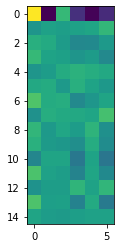

In [7]:
plt.imshow(tf_semiparam_field.tf_poly_Z_field.coeff_mat)
plt.show()

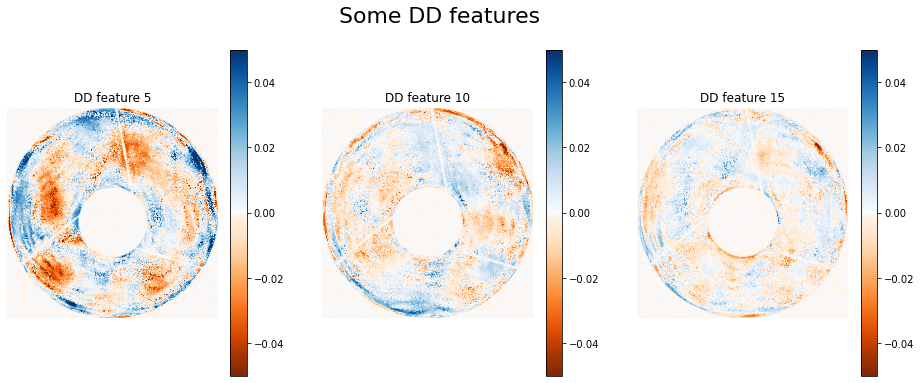

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(16,6), facecolor='white')
fig.suptitle('Some DD features', fontsize=22)

for itr in range(3):
    im = ax[itr].imshow(tf_semiparam_field.tf_np_poly_opd.S_mat[5*itr+5,:,:],cmap=newcmp, vmin=-0.05, vmax=0.05)
    plt.colorbar(im, ax=ax[itr])
    ax[itr].set_xticks([])
    ax[itr].set_title('DD feature {}'.format(5*itr+5))


for axis in ax.ravel():
    axis.axis('off')

#plt.savefig('../outputs/plots/PSF_for_each_SED.pdf')
plt.show()

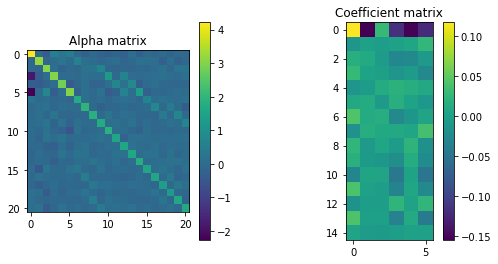

In [9]:
# Alpha matrix
fig, ax = plt.subplots(1,2, figsize=(8,4))
im = ax[0].imshow(tf_semiparam_field.tf_np_poly_opd.alpha_mat)
ax[0].set_title('Alpha matrix')
plt.colorbar(im, ax=ax[0])

# Coeff matrix
im = ax[1].imshow(tf_semiparam_field.tf_poly_Z_field.coeff_mat)
ax[1].set_title('Coefficient matrix')
plt.colorbar(im, ax=ax[1])
plt.show()

# Generate WFE and PSF

In [10]:
# Select any star from the 2000 test stars
test_star = 3

test_dataset = np.load(args['dataset_folder']+args['test_dataset_file'], allow_pickle=True)[()]
pos = test_dataset['positions'][test_star:test_star+1,:]

test_SEDs = test_dataset['SEDs']

In [11]:
# Ground truth WFE and WFE proyection on first 15 zernikes
param_opd_maps_GT = tf.tensordot(tf_zernike_cube_gt, tf.constant(test_dataset['zernike_coef'][test_star,:,0],dtype=tf.float32), axes=[0,0])
param_opd_maps_GT_low_Z = tf.tensordot(tf_zernike_cube, tf.constant(test_dataset['zernike_coef'][test_star,:args['n_zernikes'],0],dtype=tf.float32), axes=[0,0])

In [12]:
# Non parametric WFE
nonparam_opd_maps = tf_semiparam_field.tf_np_poly_opd(pos)
# Parametric WFE
zernike_coeffs = tf_semiparam_field.tf_poly_Z_field(pos)
param_opd_maps = tf_semiparam_field.tf_zernike_OPD(zernike_coeffs)
# Total WFE
opd_maps = param_opd_maps + nonparam_opd_maps

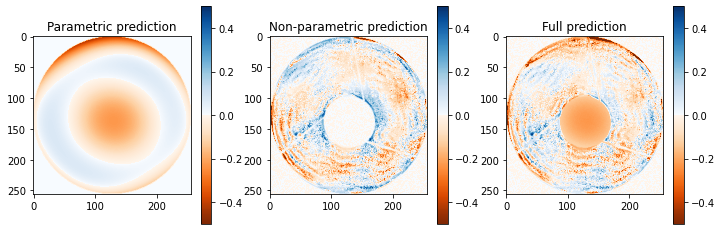

In [13]:
# Show parametric, non-parametric and total WFE
fig, ax = plt.subplots(1,3, figsize=(12,4))
im = ax[0].imshow(param_opd_maps[0,:,:], cmap=newcmp, vmax=0.5, vmin=-0.5)
ax[0].set_title('Parametric prediction')
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(nonparam_opd_maps[0,:,:], cmap=newcmp, vmax=0.5, vmin=-0.5)
ax[1].set_title('Non-parametric prediction')
plt.colorbar(im, ax=ax[1])
im = ax[2].imshow(opd_maps[0,:,:], cmap=newcmp, vmax=0.5, vmin=-0.5)
ax[2].set_title('Full prediction')
plt.colorbar(im, ax=ax[2])

plt.show()

## Get poly PSF

In [14]:
packed_SED_data = [
        wf_utils.generate_packed_elems(_sed, simPSF_np, n_bins=args['n_bins_lda'])
        for _sed in test_SEDs
    ]

# Prepare the inputs for the training
tf_packed_SED_data = tf.convert_to_tensor(packed_SED_data, dtype=tf.float32)
tf_packed_SED_data = tf.transpose(tf_packed_SED_data, perm=[0, 2, 1])

In [15]:
poly_psfs = tf_semiparam_field.tf_batch_poly_PSF([opd_maps, tf_packed_SED_data[test_star:test_star+1,:,:]])

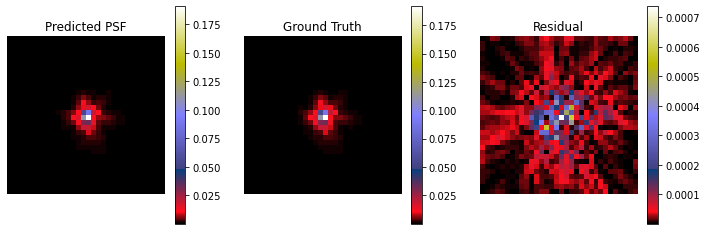

In [16]:
# Show parametric, non-parametric and total WFE
fig, ax = plt.subplots(1,3, figsize=(12,4))
im = ax[0].imshow(poly_psfs[0,:,:], cmap='gist_stern')
plt.colorbar(im, ax=ax[0])
ax[0].axis('off')
ax[0].set_title('Predicted PSF')
im = ax[1].imshow(test_dataset['stars'][test_star,:,:], cmap='gist_stern')
plt.colorbar(im, ax=ax[1])
ax[1].axis('off')
ax[1].set_title('Ground Truth')
im = ax[2].imshow(np.abs(poly_psfs[0,:,:]-test_dataset['stars'][test_star,:,:]), cmap='gist_stern')
plt.colorbar(im, ax=ax[2])
ax[2].axis('off')
ax[2].set_title('Residual')

plt.show()

# Extract low order WFE

In [17]:
def PI_zernikes(tf_z1,tf_z2,norm_factor=None):
    """ Compute internal product between zernikes and OPDs

    Defined such that Zernikes are orthonormal to each other    
    """
    if norm_factor is None:
        norm_factor = 1
    return np.sum((tf.math.multiply(tf_z1,tf_z2) ).numpy())/(norm_factor)

n_pix_zernike = PI_zernikes(tf_zernike_cube[0,:,:],tf_zernike_cube[0,:,:])

In [18]:
# Multiply Alpha matrix with DD features matrix S
inter_res_v2 = tf.tensordot(tf_semiparam_field.tf_np_poly_opd.alpha_mat[:tf_semiparam_field.tf_poly_Z_field.coeff_mat.shape[1],:], tf_semiparam_field.tf_np_poly_opd.S_mat, axes=1)
# Project over first 15 Zernikes
delta_C_poly = tf.constant(np.array([[PI_zernikes(tf_zernike_cube[i,:,:], inter_res_v2[j,:,:], n_pix_zernike) for j in range(tf_semiparam_field.tf_poly_Z_field.coeff_mat.shape[1]) ] for i in range(tf_semiparam_field.n_zernikes) ]), dtype=tf.float32)


In [19]:
# Corrected parametric coeff matrix
new_C_poly = tf_semiparam_field.tf_poly_Z_field.coeff_mat + delta_C_poly

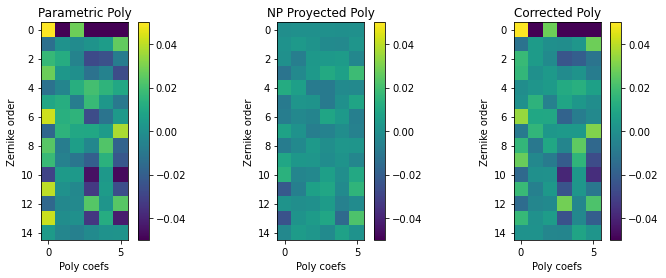

In [20]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
im = ax[0].imshow(tf_semiparam_field.tf_poly_Z_field.coeff_mat, vmax=0.05, vmin=-0.05)
plt.colorbar(im, ax=ax[0])
ax[0].set_xlabel('Poly coefs')
ax[0].set_ylabel('Zernike order')
ax[0].set_title('Parametric Poly')
im = ax[1].imshow(delta_C_poly, vmax=0.05, vmin=-0.05)
plt.colorbar(im, ax=ax[1])
ax[1].set_xlabel('Poly coefs')
ax[1].set_ylabel('Zernike order')
ax[1].set_title('NP Proyected Poly')
im = ax[2].imshow(new_C_poly, vmax=0.05, vmin=-0.05)
plt.colorbar(im, ax=ax[2])
ax[2].set_xlabel('Poly coefs')
ax[2].set_ylabel('Zernike order')
ax[2].set_title('Corrected Poly')

plt.show()

In [21]:
# Load new C_poly and get the WFE
tf_semiparam_field.tf_poly_Z_field.assign_coeff_matrix(new_C_poly)
# Parametric WFE
zernike_coeffs_new = tf_semiparam_field.tf_poly_Z_field(pos)
param_opd_maps_new = tf_semiparam_field.tf_zernike_OPD(zernike_coeffs_new)

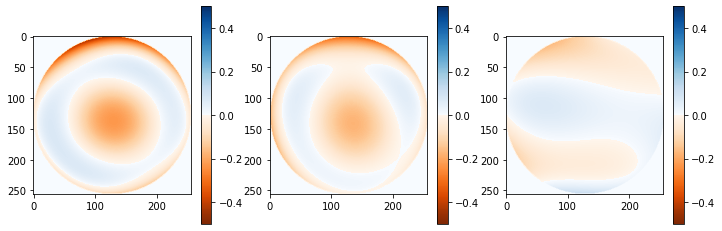

In [22]:
# Show parametric, non-parametric and total WFE
fig, ax = plt.subplots(1,3, figsize=(12,4))
im = ax[0].imshow(param_opd_maps[0,:,:], cmap=newcmp, vmax=0.5, vmin=-0.5)
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(param_opd_maps_new[0,:,:], cmap=newcmp, vmax=0.5, vmin=-0.5)
plt.colorbar(im, ax=ax[1])
im = ax[2].imshow(param_opd_maps_GT_low_Z, cmap=newcmp, vmax=0.5, vmin=-0.5)
plt.colorbar(im, ax=ax[2])

plt.show()

In [23]:
# Extract first 15 zernike amplitudes from the Full predicted WFE
full_opd_prediction_15_z_coeff = tf.constant(np.array([PI_zernikes(tf_zernike_cube[i,:,:], opd_maps[0,:,:], n_pix_zernike) for i in range(tf_semiparam_field.n_zernikes) ]), dtype=tf.float32)

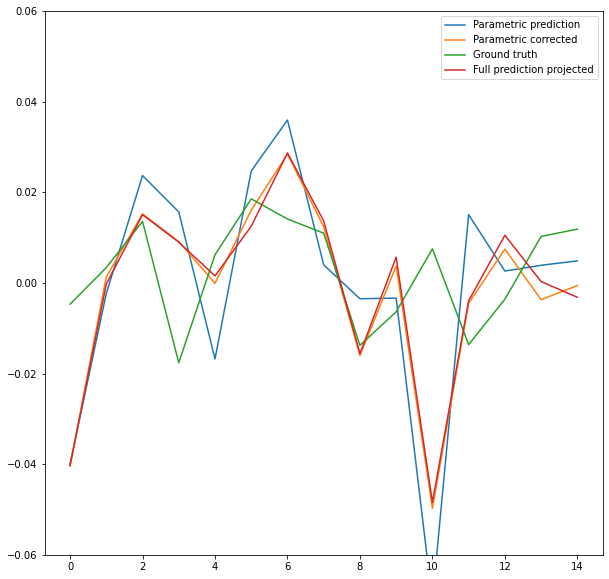

In [24]:
plt.figure(figsize=(10,10))
plt.plot(zernike_coeffs[0,:,0,0], label='Parametric prediction')
plt.plot(zernike_coeffs_new[0,:,0,0], label='Parametric corrected')
plt.plot(test_dataset['zernike_coef'][test_star,:15,0], label='Ground truth')
plt.plot(full_opd_prediction_15_z_coeff, label='Full prediction projected')
plt.legend()
plt.ylim((-0.06, 0.06))
plt.show()

# Remove extracted features from NP model

In [25]:
"""
Steps:

    1. Get beta_tilde ---->  (alpha*S_mat)[0:6,:,:] proyected on each Zernike[0:15].
    2. Invert alpha matrix
    3. Get beta as: beta = alpha^-1 * beta_tilde
    4. Get the S_mat projected: S_p = beta * Z_cube
    5. Subtract S_p to S ----> S_new = S - S_p

"""

'\nSteps:\n\n    1. Get beta_tilde ---->  (alpha*S_mat)[0:6,:,:] proyected on each Zernike[0:15].\n    2. Invert alpha matrix\n    3. Get beta as: beta = alpha^-1 * beta_tilde\n    4. Get the S_mat projected: S_p = beta * Z_cube\n    5. Subtract S_p to S ----> S_new = S - S_p\n\n'

In [26]:
S_tilde = tf.tensordot(tf_semiparam_field.tf_np_poly_opd.alpha_mat, tf_semiparam_field.tf_np_poly_opd.S_mat, axes=1)

beta_tilde_inner = np.array([[PI_zernikes(tf_zernike_cube[j,:,:], S_tilde_slice, n_pix_zernike) for j in range(tf_semiparam_field.n_zernikes) ] for S_tilde_slice in S_tilde[:tf_semiparam_field.tf_poly_Z_field.coeff_mat.shape[1],:,:] ])


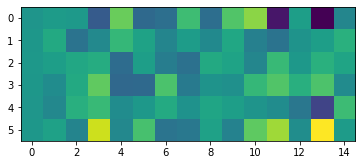

In [27]:
plt.imshow(beta_tilde_inner)

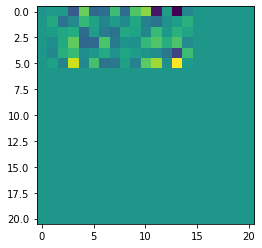

In [28]:
beta_tilde = np.pad(beta_tilde_inner, [(0, S_tilde.shape[0]-beta_tilde_inner.shape[0]), (0, S_tilde.shape[0]-beta_tilde_inner.shape[1])], mode='constant')
plt.imshow(beta_tilde)

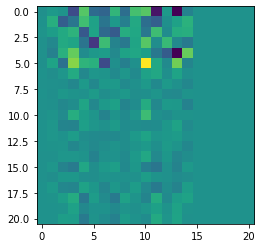

In [29]:
beta = tf.constant(np.linalg.inv(tf_semiparam_field.tf_np_poly_opd.alpha_mat) @ beta_tilde , dtype=tf.float32)
plt.imshow(beta)

In [30]:
S_mat_projected = tf.tensordot(beta[:,:tf_semiparam_field.n_zernikes],tf_zernike_cube, axes=[1,0])


In [31]:
S_new = tf_semiparam_field.tf_np_poly_opd.S_mat - S_mat_projected

In [32]:
# Load the new S matrix
tf_semiparam_field.tf_np_poly_opd.S_mat =  S_new
# Non parametric WFE
nonparam_opd_maps_new = tf_semiparam_field.tf_np_poly_opd(pos)

In [33]:
new_opd_maps = param_opd_maps_new + nonparam_opd_maps_new

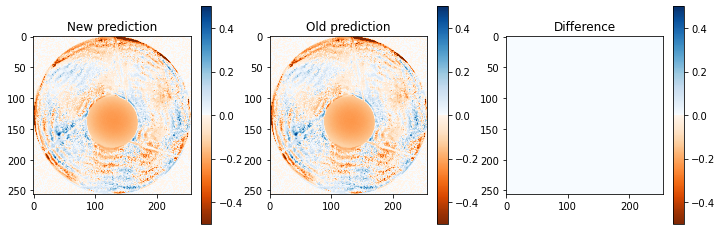

In [34]:
# Show parametric, non-parametric and total WFE
fig, ax = plt.subplots(1,3, figsize=(12,4))
im = ax[0].imshow(new_opd_maps[0,:,:], cmap=newcmp, vmax=0.5, vmin=-0.5)
ax[0].set_title('New prediction')
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(opd_maps[0,:,:], cmap=newcmp, vmax=0.5, vmin=-0.5)
ax[1].set_title('Old prediction')
plt.colorbar(im, ax=ax[1])
im = ax[2].imshow(np.abs(new_opd_maps[0,:,:] - opd_maps[0,:,:]), cmap=newcmp, vmax=0.5, vmin=-0.5)
ax[2].set_title('Difference')
plt.colorbar(im, ax=ax[2])

plt.show()

# Projection Function

In [47]:
def project_DD_features(tf_semiparam_field:tf_psf_field.TF_SemiParam_field,tf_zernike_cube):
    """
    This function is incorporated as a method of the TF_SemiParam_field class. 
    """
    # Compute Zernike norm for projections
    n_pix_zernike = PI_zernikes(tf_zernike_cube[0,:,:],tf_zernike_cube[0,:,:])
    # Multiply Alpha matrix with DD features matrix S
    inter_res_v2 = tf.tensordot(tf_semiparam_field.tf_np_poly_opd.alpha_mat[:tf_semiparam_field.tf_poly_Z_field.coeff_mat.shape[1],:], tf_semiparam_field.tf_np_poly_opd.S_mat, axes=1)
    # Project over first 15 Zernikes
    delta_C_poly = tf.constant(np.array([[PI_zernikes(tf_zernike_cube[i,:,:], inter_res_v2[j,:,:], n_pix_zernike) for j in range(tf_semiparam_field.tf_poly_Z_field.coeff_mat.shape[1]) ] for i in range(tf_semiparam_field.n_zernikes) ]), dtype=tf.float32)
    old_C_poly = tf_semiparam_field.tf_poly_Z_field.coeff_mat
    # Corrected parametric coeff matrix
    new_C_poly = old_C_poly + delta_C_poly
    tf_semiparam_field.assign_coeff_matrix(new_C_poly)

    # Remove extracted features from non-parametric model
    """
    Steps:

    1. Get beta_tilde ---->  (alpha*S_mat)[0:6,:,:] proyected on each Zernike[0:15].
    2. Invert alpha matrix
    3. Get beta as: beta = alpha^-1 * beta_tilde
    4. Get the S_mat projected: S_p = beta * Z_cube
    5. Subtract S_p to S ----> S_new = S - S_p

    """
    S_tilde = tf.tensordot(tf_semiparam_field.tf_np_poly_opd.alpha_mat, tf_semiparam_field.tf_np_poly_opd.S_mat, axes=1)
    beta_tilde_inner = np.array([[PI_zernikes(tf_zernike_cube[j,:,:], S_tilde_slice, n_pix_zernike) for j in range(tf_semiparam_field.n_zernikes) ] for S_tilde_slice in S_tilde[:tf_semiparam_field.tf_poly_Z_field.coeff_mat.shape[1],:,:] ])
    beta_tilde = np.pad(beta_tilde_inner, [(0, S_tilde.shape[0]-beta_tilde_inner.shape[0]), (0, S_tilde.shape[0]-beta_tilde_inner.shape[1])], mode='constant')
    beta = tf.constant(np.linalg.inv(tf_semiparam_field.tf_np_poly_opd.alpha_mat) @ beta_tilde , dtype=tf.float32)
    S_mat_projected = tf.tensordot(beta[:,:tf_semiparam_field.n_zernikes],tf_zernike_cube, axes=[1,0])
    S_new = tf_semiparam_field.tf_np_poly_opd.S_mat - S_mat_projected
    tf_semiparam_field.assign_S_mat(S_new)

    

### Test function

In [35]:
tf_semiparam_field = tf_psf_field.TF_SemiParam_field(
            zernike_maps=tf_zernike_cube,
            obscurations=tf_obscurations,
            batch_size=args['batch_size'],
            output_Q=args['output_q'],
            d_max_nonparam=args['d_max_nonparam'],
            l2_param=args['l2_param'],
            output_dim=args['output_dim'],
            n_zernikes=args['n_zernikes'],
            d_max=args['d_max'],
            x_lims=args['x_lims'],
            y_lims=args['y_lims']
        )
# Load the model's weights
tf_semiparam_field.load_weights(weights_paths)

In [36]:
# Parametric WFE
zernike_coeffs_before = tf_semiparam_field.tf_poly_Z_field(pos)
param_opd_maps_before = tf_semiparam_field.tf_zernike_OPD(zernike_coeffs_before)

# C_poly_proj, S_mat_new = project_DD_features(tf_semiparam_field=tf_semiparam_field, tf_zernike_cube=tf_zernike_cube)
# tf_semiparam_field.tf_poly_Z_field.assign_coeff_matrix(C_poly_proj)
# tf_semiparam_field.tf_np_poly_opd.S_mat = S_mat_new
tf_semiparam_field.project_DD_features(tf_zernike_cube)

# Parametric WFE
zernike_coeffs_after = tf_semiparam_field.tf_poly_Z_field(pos)
param_opd_maps_after = tf_semiparam_field.tf_zernike_OPD(zernike_coeffs_after)

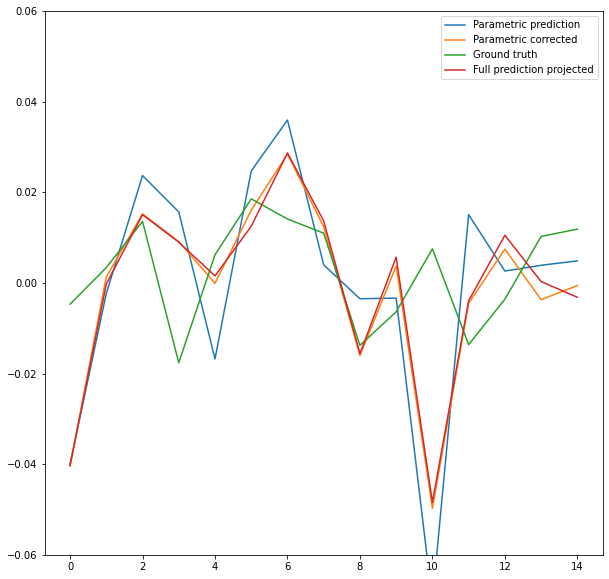

In [37]:
plt.figure(figsize=(10,10))
plt.plot(zernike_coeffs_before[0,:,0,0], label='Parametric prediction')
plt.plot(zernike_coeffs_after[0,:,0,0], label='Parametric corrected')
plt.plot(test_dataset['zernike_coef'][test_star,:15,0], label='Ground truth')
plt.plot(full_opd_prediction_15_z_coeff, label='Full prediction projected')
plt.legend()
plt.ylim((-0.06, 0.06))
plt.show()